In [15]:
import tensorflow as tf
import numpy as np
from common import *
from matplotlib import pyplot as plt

In [16]:
MODEL_PATH = '../tflite_models/float32/yolov8n.tflite'
IMG_PATH = '../COCO/val2017/000000175251.jpg'
LABEL_PATH = 'coco_labels_actual.txt'

In [17]:
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print(input_img_shape, input_type)

(640, 640) <class 'numpy.float32'>


In [18]:
original_img, scaled_img = preprocess_image(IMG_PATH, input_img_shape, input_type)

scaled_img /= 255.0

In [19]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
out = interpreter.get_tensor(output_details[0]['index']).squeeze()

bboxes = out[:4, :].T
for bbox in bboxes:
    bbox_ratios = bbox / scaled_img.shape[1]
    x_c, y_c, w, h = bbox_ratios
    bbox[0] = (x_c - w / 2) * original_img.shape[1]
    bbox[1] = (y_c - h / 2) * original_img.shape[0]
    bbox[2] = (x_c + w / 2) * original_img.shape[1]
    bbox[3] = (y_c + h / 2) * original_img.shape[0]

bboxes = bboxes.astype(np.int32)
all_scores = out[4:, :]
class_ids = np.argmax(all_scores, axis=0)
scores = all_scores[class_ids, np.arange(all_scores.shape[1])]

In [20]:
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.2,
    score_threshold=0.25
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

fix_missing_labels(class_ids)

class_ids += 1

[ 1 90]


50 19 612 611
327 348 518 405


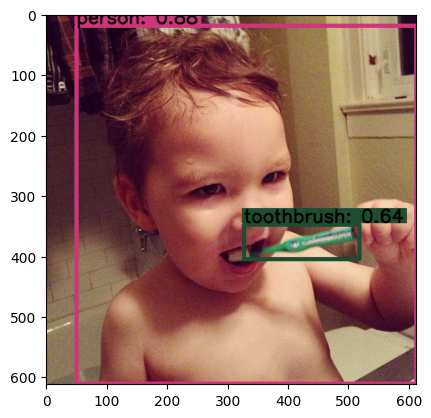

In [21]:
labels = get_coco_labels(LABEL_PATH)
colors = get_colors_from_labels(labels)

for bbox, class_id, score in zip(bboxes, class_ids, scores):
    label = labels[int(class_id)]

    color = tuple([int(c) for c in colors[int(class_id)]])
    x_min, y_min, x_max, y_max = bbox
    print(x_min, y_min, x_max, y_max)
    draw_bbox_with_label(original_img, x_min, y_min, x_max, y_max, score, label, color)


plt.imshow(original_img)